In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [31]:
import gpytorch.means as means
import torch
from botorch.utils.transforms import normalize

from autorocks.data.dataset import BOSystemDataset
from autorocks.data.debugger import OfflineDebugger
from autorocks.dir_struct import ProcessedDataDir
from autorocks.optimizer.bograph.dag_dao.model_nodes.node_singlegp import SingleTaskGPModelNode
import os

os.environ["SYSTEM_MEMORY"] = "16gb"
from autorocks.envs.postgres.schema import PostgresParametersCollection10

sys_param = PostgresParametersCollection10()
dataset = BOSystemDataset(
    historic_data_path=ProcessedDataDir / "postgres/latency_p99/ycsb/10_params/100_iter",
    parameters_name=[p.name for p in sys_param.parameters()],
    objectives_name=["bench_res.latency_p99"],
    transform=lambda X: normalize(X, bounds=torch.tensor(sys_param.bounds().T)),
    target_transform=lambda X: -X,
)


debugger = OfflineDebugger(
    observed_dataset=dataset,
    model_callable=lambda train_x, train_y: SingleTaskGPModelNode(train_x=train_x, train_y=train_y),
    shuffle_dataset=True,
)

# Set different dataset to try to replay the learning process
# dataset.set_dataset("BoTorch", 0)

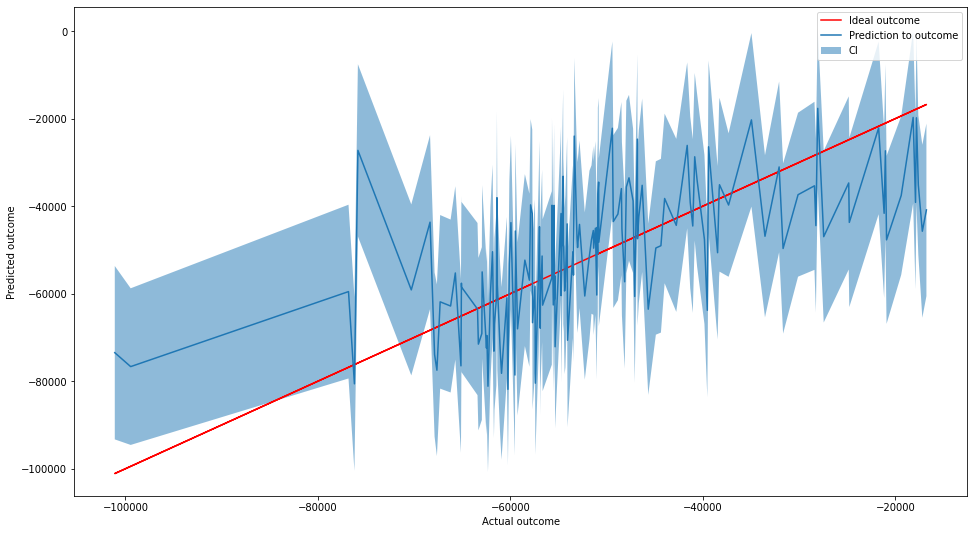

In [36]:
analysis_res = debugger.regress_against_all_dataset(70)

analysis_res.fig

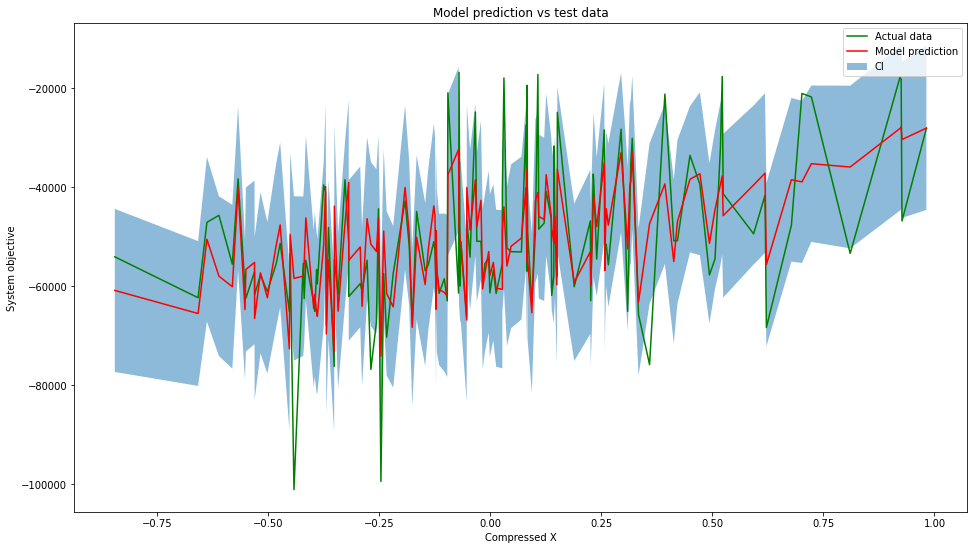

In [33]:
debugger.regress_on_top_of_test(step=50)

Candidate: tensor([[1., 1., 1., 0., 0., 1., 0., 0., 1., 0.]], dtype=torch.float64), ACQF_Value: 24141.91472103157


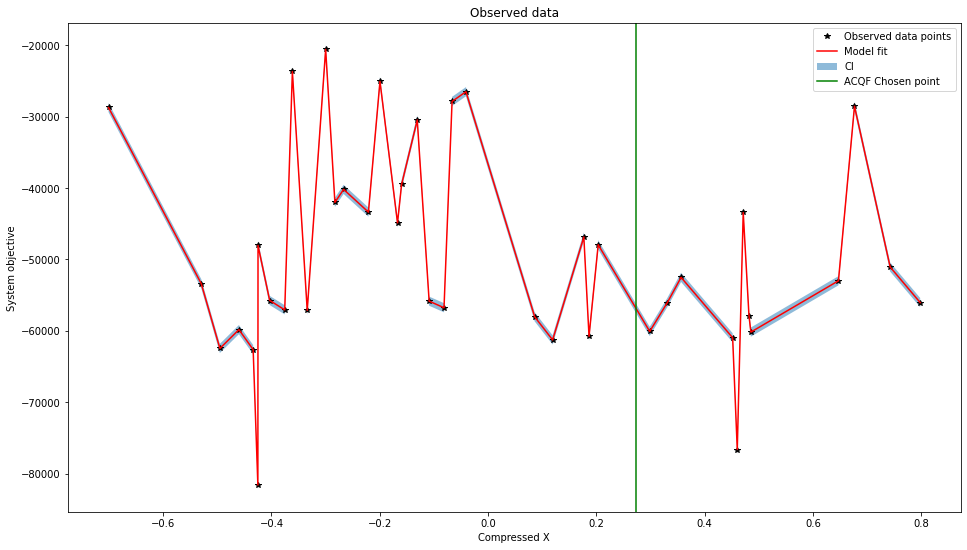

In [34]:
from autorocks.optimizer.acqf import AcqfOptimizerCfg
from botorch.sampling import SobolQMCNormalSampler
import autorocks.optimizer.acqf as acqf_wrapper


debugger.regression_at_step(
    40,
    acqf_wrapper=acqf_wrapper.qExpectedImprovementWrapper(
        sampler=SobolQMCNormalSampler(num_samples=1024),
        optimizer_cfg=(AcqfOptimizerCfg(dim=sys_param.dimensions)),
    ),
)